# King et al 2020 E-T-L

**Authorship:**<br>
Created by: Adam Klie, *11/18/2022*
Last updated: Adam Klie, *11/18/2022*
***
**Description:**

***

In [3]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

import os
import numpy as np
import pandas as pd
import eugene as eu

# Configure EUGENe 
print(eu.__version__)
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene" 
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/tests/_logs/king20"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/tests/_output/king20"

0.0.4


# Load data

## `king20()` dataset function

In [278]:
def king20(
    dataset = "SYN", 
    return_sdata=True, 
    download_mm10=False,
    **kwargs: dict
):
    urls_list = [
        "https://elifesciences.org/download/aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5vcmcvYXJ0aWNsZXMvNDEyNzkvZWxpZmUtNDEyNzktc3VwcDEtdjIueGxzeA--/elife-41279-supp1-v2.xlsx?_hash=nX7V5q5UXEGDbCoqhF23ru1RNUI14CBnHk27Cxlpgr4%3D",
        "https://elifesciences.org/download/aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5vcmcvYXJ0aWNsZXMvNDEyNzkvZWxpZmUtNDEyNzktc3VwcDItdjIueGxzeA--/elife-41279-supp2-v2.xlsx?_hash=V%2FARKgB5fn%2FUe1zKqVdBFHuq7na8rU%2BuFcWIQQwnAPM%3D",
        "https://elifesciences.org/download/aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5vcmcvYXJ0aWNsZXMvNDEyNzkvZWxpZmUtNDEyNzktc3VwcDQtdjIuZmFzdGE-/elife-41279-supp4-v2.fasta?_hash=HEFd7o2rJQ5Be4CHpN3L9SnE0zbrhhJah%2Fgao0poWG0%3D",
        "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M31/GRCm39.genome.fa.gz"
    ]
    paths = [
        os.path.join(eu.settings.dataset_dir, "king20", "design.xlsx"),
        os.path.join(eu.settings.dataset_dir, "king20", "models.xlsx"),
        os.path.join(eu.settings.dataset_dir, "king20", "GEN.fasta"),
        os.path.join(eu.settings.dataset_dir, "king20", "GRCm39.genome.fa.gz")
    ]
    
    # Design excel
    print(f"Downloading king20 design spreadsheet to {paths[0]}")
    os.system("wget -q -O {0} {1}".format(paths[0], urls_list[0]))
    print(f"Finished downloading king20 design spreadsheet to {paths[0]}")
    
    # Mode excel
    print(f"Downloading king20 model spreadsheet to {paths[1]}")
    os.system("wget -q -O {0} {1}".format(paths[1], urls_list[1]))
    print(f"Finished downloading king20 spreadsheet to {paths[1]}")
    
    
    if dataset == "SYN":
        seq_tbl = pd.read_excel(paths[0], sheet_name=1)
        seq_tbl_filt = seq_tbl[~seq_tbl["Sequence"].duplicated()]
        model_tbl = pd.read_excel(paths[1], sheet_name=4)
        merged_tbl = pd.merge(seq_tbl_filt, model_tbl, on="Element_id", how="outer")
    elif dataset == "GEN":
        seq_tbl = pd.read_excel(paths[0], sheet_name=6)
        seq_tbl_filt = seq_tbl[~seq_tbl["Element_id"].duplicated()]
        seq_tbl_wt = seq_tbl_filt[seq_tbl_filt["Element_id"].str.contains("Genomic")]
        exp_summary = pd.read_excel(paths[0], sheet_name=7)
        merged = pd.merge(seq_tbl_wt, exp_summary, on="Element_id", how="left")
        bc_grouped = merged.groupby("Element_id").agg("mean")
        CRE_norm_expression_WT_all = bc_grouped[["Rep1_Element_normalized", "Rep2_Element_normalized","Rep3_Element_normalized"]].mean(axis=1)
        bc_grouped["CRE_norm_expression_WT_all"] = CRE_norm_expression_WT_all
        bc_grouped["Sequence"] = merged.groupby("Element_id").agg({"Sequence": lambda x: x.iloc[0]})["Sequence"]
        merged_tbl = bc_grouped.reset_index()[["Sequence", "Element_id", "CRE_norm_expression_WT_all"]]
        merged_tbl["Element_id"] = merged_tbl["Element_id"].str.replace("_Genomic", "")
        merged_tbl["Barcode"] = "NA"
        
        print(f"Downloading king20 gkmsvm fasta to {paths[2]}")
        os.system("wget -q -O {0} {1}".format(paths[2], urls_list[2]))
        print(f"Finished downloading king20 gkmsvm fasta to {paths[2]}")
        
        if download_mouse:
            print(f"Downloading mm10 fasta to {paths[2]}")
            os.system("wget -q -O {0} {1}".format(paths[3], urls_list[3]))
            print(f"Finished downloading mm10 fasta to {paths[0]}")
    else:
        raise ValueError("dataset must be either 'SYN' or 'GEN'.")
    if return_sdata:
        seq_col = "Sequence"
        sdata = eu.dl.SeqData(
            seqs=merged_tbl["Sequence"],
            names=merged_tbl["Element_id"],
            seqs_annot=merged_tbl.drop(["Barcode", "Sequence"], axis=1).set_index("Element_id")
        )
        return sdata
    else:
        return paths

In [280]:
sdata = king20("GEN")

Finished downloading king20 design spreadsheet to /cellar/users/aklie/data/eugene/king20/design.xlsx
Finished downloading king20 spreadsheet to /cellar/users/aklie/data/eugene/king20/models.xlsx
Finished downloading king20 gkmsvm fasta to /cellar/users/aklie/data/eugene/king20/GEN.fasta
Finished downloading mm10 fasta to /cellar/users/aklie/data/eugene/king20/design.xlsx


In [283]:
sdata

SeqData object with = 403 seqs
seqs = (403,)
names = (403,)
rev_seqs = None
ohe_seqs = None
ohe_rev_seqs = None
seqs_annot: 'CRE_norm_expression_WT_all', 'chr', 'start', 'end'
pos_annot: None
seqsm: None
uns: None

In [281]:
eu.pp.add_ranges_sdata(sdata)

SeqData object modified:
    seqs_annot:
        + start, end, chr


In [282]:
sdata.seqs_annot

,CRE_norm_expression_WT_all,chr,start,end
Element_id,,,,
chr10:108456620-108456701,2.292053,chr10,108456620,108456701
chr10:110940873-110940954,1.026702,chr10,110940873,110940954
chr10:115312950-115313031,1.818395,chr10,115312950,115313031
chr10:128631710-128631792,1.059821,chr10,128631710,128631792
chr10:18597642-18597724,0.827090,chr10,18597642,18597724
...,...,...,...,...
chr9:9961010-9961092,1.022724,chr9,9961010,9961092
chrX:114694676-114694758,1.952495,chrX,114694676,114694758
chrX:134296640-134296721,1.326962,chrX,134296640,134296721


In [294]:
eu.dl.motif.get_jaspar_motifs(motif_accs=["MA0627.1", "MA0143.3", "MA0141.1", "MA0039.2"])

In [296]:
eu.dl.motif.jaspar_annots_sdata(
    sdata,
    motif_accs=["MA0627.1", "MA0143.3", "MA0141.1", "MA0039.2"],
    filename="/cellar/users/aklie/data/eugene/king20/motifs.meme"
)

Saved PWM File as : /cellar/users/aklie/data/eugene/king20/motifs.meme


In [298]:
sdata.pos_annot

,Chromosome,Start,End,Strand,Score,Pvalue,Qvalue,Accession,Name
0,chr1:20908643-20908725,14,21,+,12.989796,0.000071,0.064660,MA0143,Sox2
1,chr1:20908643-20908725,73,62,-,14.846939,0.000006,0.009156,MA0141,Esrrb
2,chr1:36105279-36105361,51,40,-,16.173469,0.000001,0.006548,MA0141,Esrrb
3,chr1:38418914-38418996,35,46,+,16.020408,0.000002,0.006601,MA0141,Esrrb
4,chr1:39459379-39459460,20,27,+,13.530612,0.000044,0.064660,MA0143,Sox2
...,...,...,...,...,...,...,...,...,...
346,chr19:37401085-37401167,57,68,+,14.897959,0.000006,0.008804,MA0141,Esrrb
347,chr19:43606979-43607060,36,25,-,10.479592,0.000084,0.036812,MA0141,Esrrb
348,chrX:114694676-114694758,52,63,+,11.775510,0.000042,0.024820,MA0141,Esrrb
349,chrX:114694676-114694758,56,41,-,14.242424,0.000009,0.043782,MA0627,Pou2f3


In [299]:
from pymemesuite.fimo import FIMO

In [300]:
FIMO?

Init signature:
FIMO(
    self,
    *,
    alpha=1.0,
    both_strands=True,
    threshold=0.0001,
    max_stored_scores=100000,
)
Docstring:      <no docstring>
Init docstring:
Create a new FIMO runner.

Keyword Arguments:
    alpha (`float`): The scale factor for non-specific priors,
    both_strands (`bool`): Whether or not to run the motif scan on
        both segments.
    threshold (`float`): The p-value above which matches are
        marked as non-significant and discarded.
    max_scored_scores (`int`): The maximum number of scored sites
        to keep in the result `Pattern`. Using a smaller number
        will reduce memory consumption at the cost of statistical
        accuracy, and significant results may be lost.
File:           ~/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pymemesuite/fimo.cpython-37m-x86_64-linux-gnu.so
Type:           type
Subclasses:     


## Data Visualization

In [123]:
# Add this to sanitize seqs
sdata = sdata[~np.array([seq is np.nan for seq in sdata.seqs])]

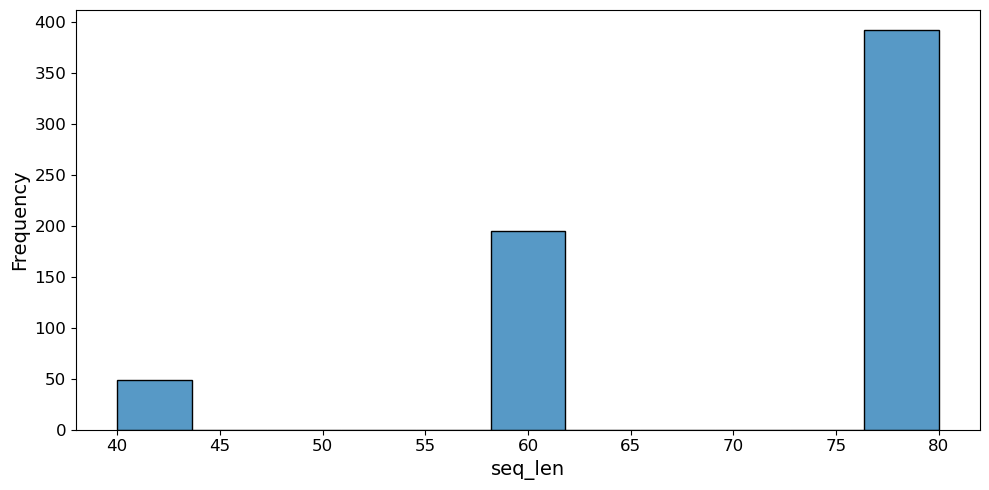

In [124]:
# Add this to some kind of preprocess seqs or seqs metrics
sdata["seq_len"] = [len(seq) for seq in sdata.seqs]
eu.pl.histplot(
    sdata, 
    keys="seq_len", 
    orient="h"
)

12


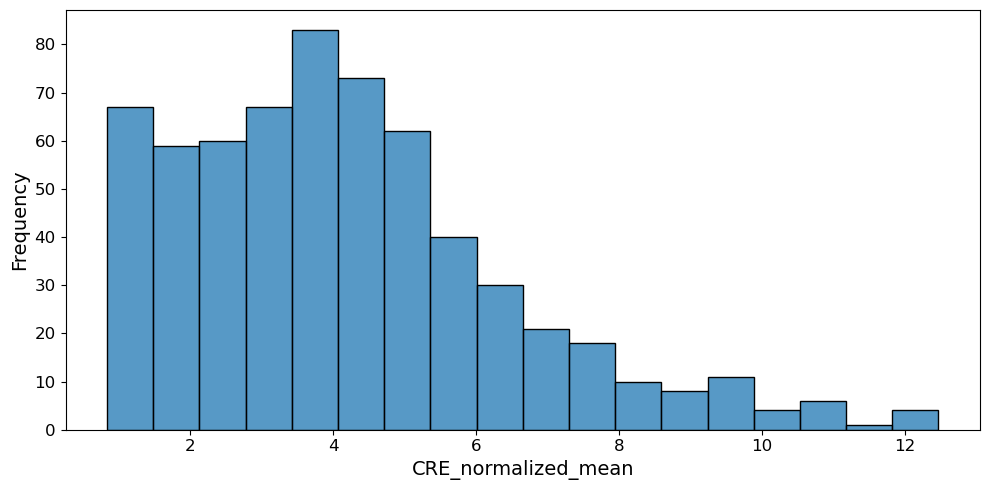

In [125]:
# Chceck the potential target to start
eu.pl.histplot(
    sdata,
    keys="CRE_normalized_mean",
    orient="h"
)
print(sdata["CRE_normalized_mean"].isna().sum())

## Preprocessing

In [126]:
# One-hot-encode, though this is no bueno
eu.pp.ohe_seqs_sdata(sdata, maxlen=sdata["seq_len"].max())

One-hot encoding sequences:   0%|          | 0/636 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 636 ohe_seqs added


In [127]:
# Add function registry for normalization
sdata["log_CRE_normalized_mean"] = np.log2(sdata["CRE_normalized_mean"])

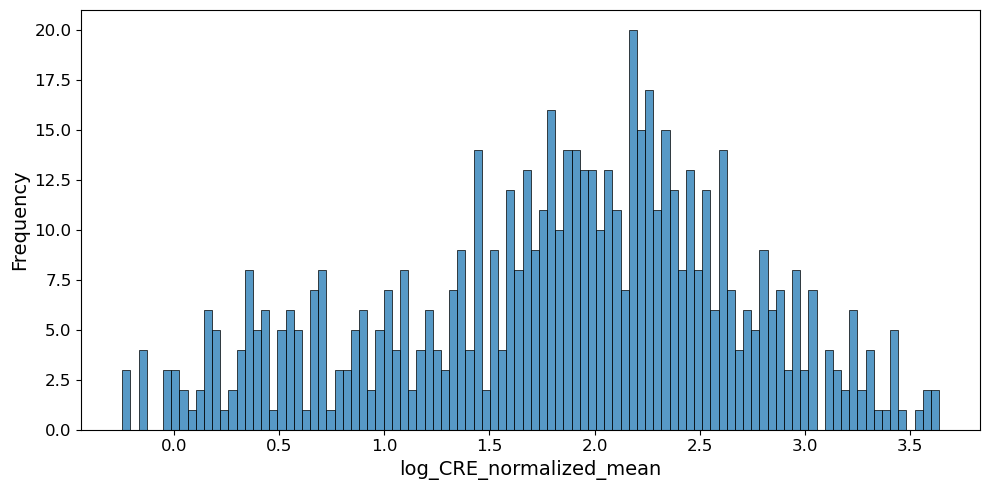

In [128]:
# Check log normalization
eu.pl.histplot(
    sdata,
    keys="log_CRE_normalized_mean",
    orient="h",
    bins=100
)

In [129]:
# Clean up features to use
sdata.seqs_annot = sdata.seqs_annot.replace({True: 1, False: 0})

In [130]:
eu.pp.train_test_split_sdata(sdata, split=0.5)

SeqData object modified:
    seqs_annot:
        + train_val


In [131]:
nan_mask = np.isnan(sdata["log_CRE_normalized_mean"])
sdata = sdata[~nan_mask]

In [132]:
sdata

SeqData object with = 624 seqs
seqs = (624,)
names = (624,)
rev_seqs = None
ohe_seqs = (624, 4, 80)
ohe_rev_seqs = None
seqs_annot: 'Sequence', 'Element_id_simplified', 'Class', 'CRE_normalized_mean', 'O_presence', 'S_presence', 'K_presence', 'E_presence', 'Position.4_O', 'Position.4_S', 'Position.4_K', 'Position.4_E', 'Position.3_O', 'Position.3_S', 'Position.3_K', 'Position.3_E', 'Position.2_O', 'Position.2_S', 'Position.2_K', 'Position.2_E', 'Position.1_O', 'Position.1_S', 'Position.1_K', 'Position.1_E', 'seq_len', 'log_CRE_normalized_mean', 'train_val'
pos_annot: None
seqsm: None
uns: None

# Training

## Initialization

In [133]:
from sklearn.ensemble import RandomForestRegressor

In [134]:
model = RandomForestRegressor(random_state=13)

## `fit()`

In [135]:
feature_cols = sdata.seqs_annot.columns[sdata.seqs_annot.columns.str.contains("presence|Position")]

In [169]:
from sklearn.ensemble import RandomForestRegressor
from eugene._settings import settings
import threading

def fit(
    model,
    sdata,
    target_keys,
    train_key="train_val",
    features_cols = None,
    seqsm_key = None,
    threads=None,
    log_dir=None,
    name=None,
    version="",
    seed=None,
    verbosity=1
):
    # Set-up the run
    threads = threads if threads is not None else threading.active_count()
    log_dir = log_dir if log_dir is not None else settings.logging_dir
    model_name = model.__class__.__name__
    name = name if name is not None else model_name
    np.random.seed(seed) if seed is not None else np.random.seed(settings.seed)
    model.verbose = verbosity

    # Remove seqs with NaN targets
    targs = sdata.seqs_annot[target_keys].values  
    if len(targs.shape) == 1:
        nan_mask = np.isnan(targs)
    else:
        nan_mask = np.any(np.isnan(targs), axis=1)
    print(f"Dropping {nan_mask.sum()} sequences with NaN targets.")
    sdata = sdata[~nan_mask]
    targs = targs[~nan_mask]
    print(np.isnan(targs).sum())
    
    # Get train and val indeces
    train_idx = np.where(sdata.seqs_annot[train_key] == True)[0]
    val_idx = np.where(sdata.seqs_annot[train_key] == False)[0]
    
    # Get train and val targets
    train_Y = targs[train_idx].squeeze()
    val_Y = targs[val_idx].squeeze()
    
    # Get train adn val features
    if feature_cols is not None:
        sdata.seqsm[f"{model_name}_features" if seqsm_key is None else seqsm_key] = sdata.seqs_annot[feature_cols].values
    else:
        assert seqsm_key is not None
    features = sdata.seqsm[seqsm_key]
    train_X = features[train_idx]
    val_X = features[val_idx]
    model.fit(train_X, train_Y)
    
    if not os.path.exists(os.path.join(log_dir, name, version)):
        os.makedirs(os.path.join(log_dir, name, version))
        
    pd.DataFrame(pd.Series(model.get_params())).T.to_csv(os.path.join(log_dir, name, version, "hyperparams.tsv"), index=False, sep="\t")

In [170]:
fit(
    model,
    sdata,
    target_keys = "log_CRE_normalized_mean",
    train_key = "train_val",
    features_cols = "feature_cols",
    seqsm_key = "independent_position_features"
)

Dropping 0 sequences with NaN targets.
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
sdata

SeqData object with = 624 seqs
seqs = (624,)
names = (624,)
rev_seqs = None
ohe_seqs = (624, 4, 80)
ohe_rev_seqs = None
seqs_annot: 'Sequence', 'Element_id_simplified', 'Class', 'CRE_normalized_mean', 'O_presence', 'S_presence', 'K_presence', 'E_presence', 'Position.4_O', 'Position.4_S', 'Position.4_K', 'Position.4_E', 'Position.3_O', 'Position.3_S', 'Position.3_K', 'Position.3_E', 'Position.2_O', 'Position.2_S', 'Position.2_K', 'Position.2_E', 'Position.1_O', 'Position.1_S', 'Position.1_K', 'Position.1_E', 'seq_len', 'log_CRE_normalized_mean', 'train_val'
pos_annot: None
seqsm: 'independent_position_features'
uns: None

## `hyperopt`

In [ ]:
def hyperopt_with_random_cv(
    config,
    model,
    sdata,
    target_keys,
    train_key="train_val",
    features_cols = None,
    seqsm_key = None,
    threads=None,
    log_dir=None,
    name=None,
    version=None,
    seed=None,
    verbosity=1
):
    pass


def hyperopt_with_
    

# Evaluation

In [171]:
def predictions(
    model,
    sdata,
    target_keys,
    features_cols = None,
    seqsm_key = None,
    threads=None,
    store_only=False,
    out_dir=None,
    name=None,
    version="",
    file_label="",
    prefix="",
    suffix="",
    copy=False
):
    threads = threads if threads is not None else threading.active_count()
    target_keys = [target_keys] if type(target_keys) == str else target_keys
    out_dir = out_dir if out_dir is not None else settings.output_dir
    model_name = model.__class__.__name__
    name = name if name is not None else model_name
    out_dir = os.path.join(out_dir, name, version)
    
    if feature_cols is not None:
        sdata.seqsm[f"{model_name}_features"] = sdata.seqs_annot[feature_cols].values
    else:
        assert seqsm_key is not None
    features = sdata.seqsm[seqsm_key]
    ps = model.predict(features)
    ts = sdata.seqs_annot[target_keys].values.squeeze()
    inds = sdata.seqs_annot.index
    new_cols = [f"{prefix}{lab}_predictions{suffix}" for lab in target_keys]
    sdata.seqs_annot[new_cols] = np.expand_dims(model.predict(features), axis=1)
    if not store_only:
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        df = pd.DataFrame(index=inds, data={"targets": ts, "predictions": ps})
        df.to_csv(os.path.join(out_dir, f"{file_label}_predictions.tsv"), sep="\t")
    return sdata if copy else None

def train_val_predictions():
    pass

In [172]:
predictions(
    model,
    sdata,
    target_keys = "log_CRE_normalized_mean",
    seqsm_key = "independent_position_features",
    file_label = "syn"
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Group R2 MSE Spearmanr
2mer 0.17061259008224539 0.09883053880486709 0.5473634553720202
3mer 0.5737275066327123 0.11716702652214686 0.7331065672246669
4mer 0.5764634718931543 0.11139033426487625 0.7527458403771544


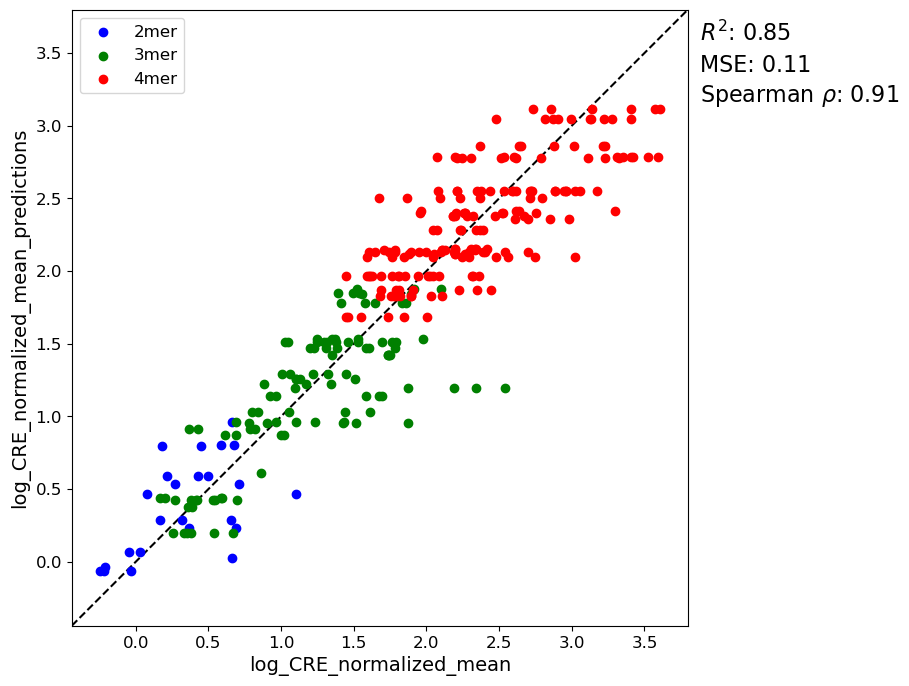

In [173]:
val_idx = np.where(sdata.seqs_annot["train_val"] == False)[0]
eu.pl.performance_scatter(
    sdata,
    target_keys="log_CRE_normalized_mean",
    prediction_keys="log_CRE_normalized_mean_predictions",
    seq_idx=val_idx,
    groupby="Class"
)

# Interpretation

## Feature attribution

In [199]:
import matplotlib.pyplot as plt
def _impurity_decrease(
    model, 
    feature_names,
    plot=True,
    prefix="",
    suffix="",
    copy=False
):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    descending_ord = np.argsort(importances)
    importances = importances[descending_ord]
    std = std[descending_ord]
    names = feature_cols[descending_ord]
    forest_importances = pd.DataFrame(data={"importances": importances, "std": std}, index=names)
    if plot:
        fig, ax = plt.subplots()
        forest_importances["importances"].plot.barh(yerr=std, ax=ax)
        ax.set_title("Feature importances using MDI")
        ax.set_ylabel("Mean decrease in impurity")
    return feature_importances_


def feature_attribution_sdata(
    sdata,
    model,
    method = "mean_impurity",
    uns_key=None,
    feature_names=None
    copy=False
):
    if method == "mean_impurity":
        uns_key if uns_key is not None else "mean_impurity_imps"
        forest_importances = _impurity_decrease(model, feature_names, plot=False, uns)
        sdata.uns[f"{prefix}uns_key{suffix}"] = forest_importances
    return sdata if copy else None

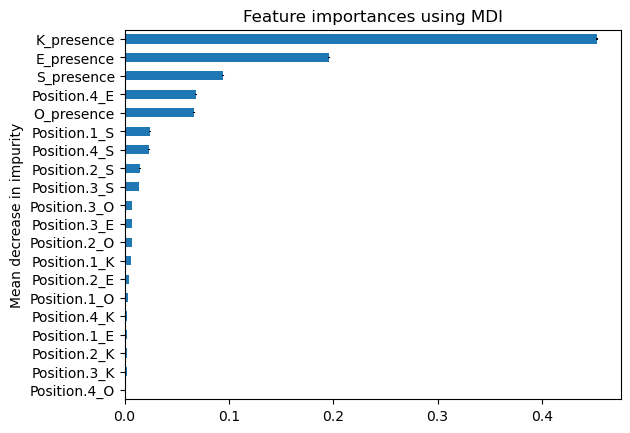

In [200]:
_impurity_decrease(sdata, model, feature_cols)

In [ ]:
def permutation_importance(
    sdata,
    model,
    n_repeats,
    seed
):
    pass

---